In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
# reflect the tables
Base = automap_base()
Base.prepare(engine, reflect=True)




In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station 

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine) 

In [10]:
#find the table names
inspector = inspect(engine)
inspector.get_table_names()


['measurement', 'station']

# Exploratory Climate Analysis

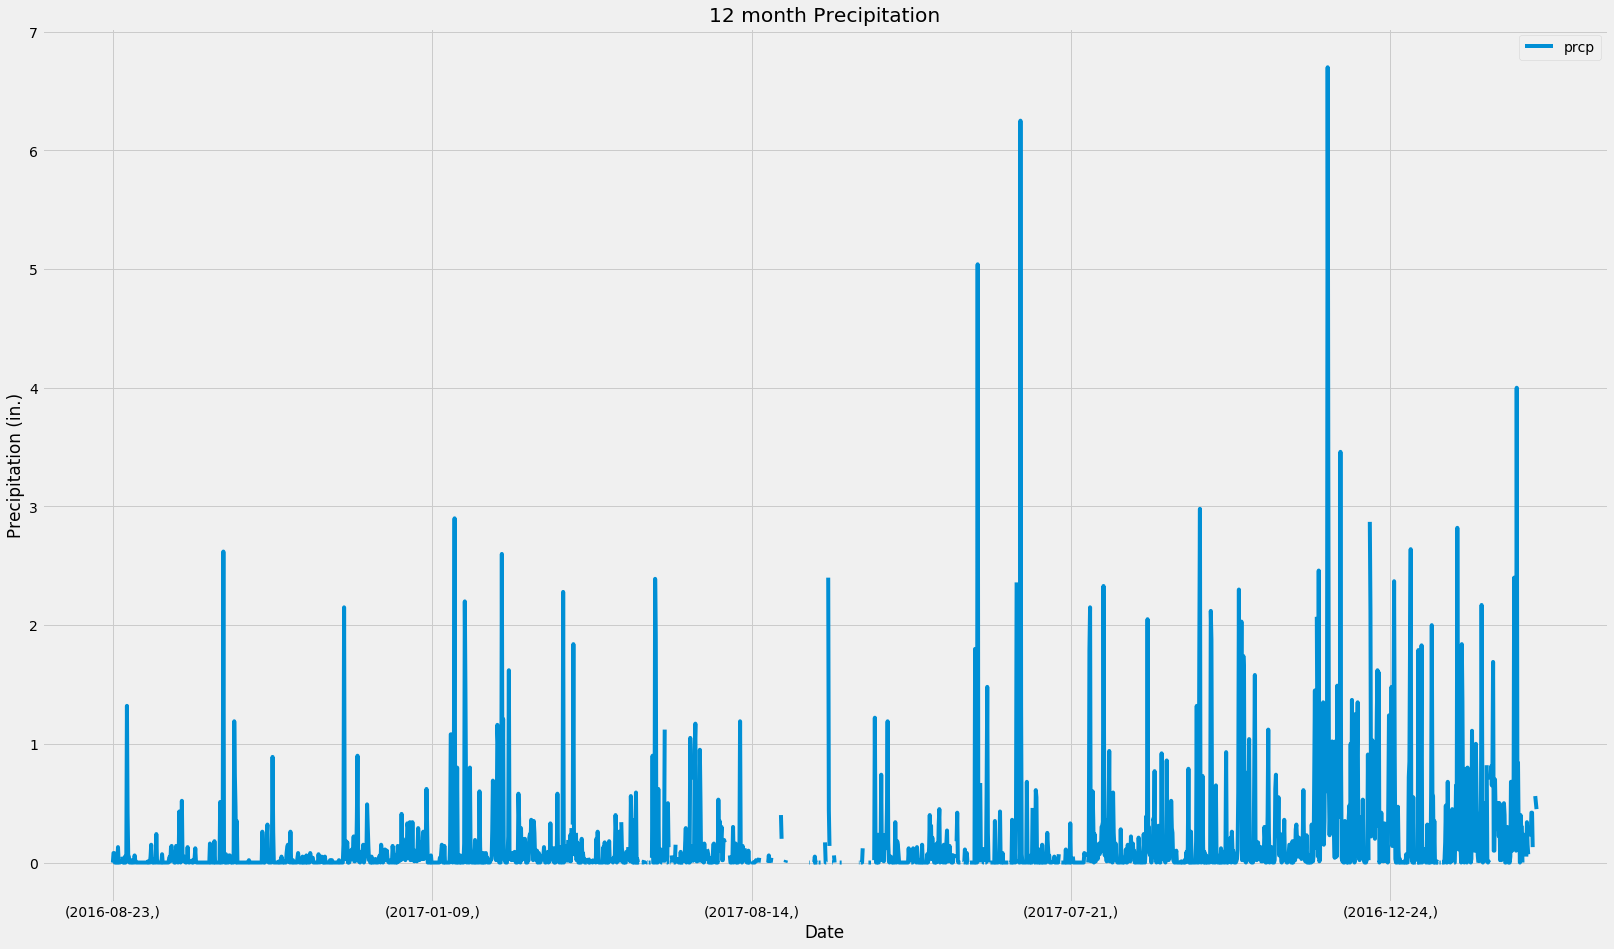

In [63]:
#create a query to find the last date in the data
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first() 
last_date

#create a query to find the date 12 months prior to the last_date
start_date = dt.date(2017, 8, 23) - dt.timedelta(weeks=52)
start_date

#create a query to find all the dates from the start_date and last_date and return the data points
last_12_months_date = session.query(Measurement.date).\
   filter(Measurement.date <= '2017-08-24', Measurement.date >= '2016-08-23').all() 

#create a query to find all the prcp values from the start_date and last_date and return the data points
last_12_months_prcp = session.query(Measurement.prcp).\
   filter(Measurement.date <= '2017-08-24', Measurement.date >= '2016-08-23').all() 

#generate a dataframe with the data pulled from the queries ans sort the values by date
prcp_date_df = pd.DataFrame(last_12_months_prcp, last_12_months_date)#, columns = ['date', 'precipitation'])
prcp_date_df.index.name = 'Date'
prcp_date_df
prcp_date_df.head(20)


#plotting the data
fig, ax = plt.subplots(figsize = (25, 15))
prcp_date_df.plot(ax = ax, x_compat = True)

#title and labels
ax.set_xlabel('Date')
ax.set_ylabel('Precipitation (in.)')
ax.set_title("12 month Precipitation")
plt.savefig("Images/precipitation.png")
plt.show()





In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_date_df.describe()


,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station.id).distinct().count()
stations

9

In [35]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_counts = (session.query(Measurement.station, func.count(Measurement.station))
                        .group_by(Measurement.station)
                        .order_by(func.count(Measurement.station).desc())
                        .all())
station_counts








[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [36]:
#create dataframe and add values into column
station_df = pd.DataFrame(station_counts, columns= ['station', 'Count'])
#find the max value
max_station_count = station_df['Count'].max()
#display the station with the highest count
highest_count_station = station_df.loc[station_df['Count'] == max_station_count]
highest_count_station

,station,Count
0,USC00519281,2772


In [57]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
most_active_station = 'USC00519281'
temps_info = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()

# highest temperature recorded, and average temperature of the most active station?
temps_info

[(54.0, 85.0, 71.66378066378067)]

In [70]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_temp_obs = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == most_active_station).\
    filter(Measurement.date <= '2017-08-24', Measurement.date >= '2016-08-23').all() 

#save as a data frame
station_temp_obs_df = pd.DataFrame(station_temp_obs, columns = ['date', 'temperature'])
station_temp_obs_df


,date,temperature
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0
...,...,...
347,2017-08-14,77.0
348,2017-08-15,77.0
349,2017-08-16,76.0
350,2017-08-17,76.0


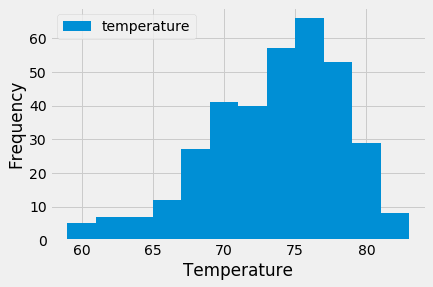

In [71]:
fig, ax = plt.subplots()
station_temp_obs_df.plot.hist(bins = 12, ax = ax)

#labels
ax.set_xlabel('Temperature')
ax.set_ylabel('Frequency')
plt.savefig("Images/temp_plot.png")
plt.show()
